# MATH6380O HWK2 - Image Captioning by Combining CNN & LSTM

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np 
import argparse
import pickle 
import os
from torch.autograd import Variable 
from torchvision import transforms 
from build_vocab import Vocabulary
from model import EncoderCNN, DecoderRNN
from PIL import Image
import torch.utils.data as data

import nltk
from nltk.translate.bleu_score import sentence_bleu
from collections import defaultdict

plt.ion()

### Description of the Image Captioning Network

![alt text][img]

[img]: https://d3ansictanv2wj.cloudfront.net/image-03-65bc895a46de9bfcd5131103c1918cad.jpg

Image Captioning problem is a task to generate description explaining the content of a given image input. The widely used method to deal with this problem is to use encoder-decoder framework. An encoder to extract information/ feature from the input image, and a decoder to generate suitable description based on the features from the encoder. 

##### Encoder

For the Encoder, Convolutional Neural Network (CNN), especially the ResNet pretrained on ILSVRC dataset is used. The ResNet extracts feature vector from given image, which then gets fed into the Decoder; the last hidden state of the CNN is connected to the Decoder.

##### Decoder 

For the decoder, Recurrent Neural Network (RNN) gets used for language modelling conditioned on the feature vector. In this case, vanilla LSTM is used to generate the captions. The source and target texts for training the decoder are predefined. For example, if the image description is "I love deep learning course", the source list is ['< start >', 'I', 'love', 'deep', 'learning', 'course'] and the target list is ['I', 'love', 'deep', 'learning', 'course', '< end >']. 

### Result and Evaluation

##### Annotation Dictionary for BLEU calculation

In [7]:
# create dictionary of dataset
def build_anno_dict(anno_dir):
    print('creating dict...')
    idToAnnos = defaultdict(list)

    with open(anno_dir) as f:
        anno_dataset = f.readlines()

    for ann in anno_dataset:
        row = ann.strip().split("\t")
        idToAnnos[row[0].split("#")[0]].append(row[1])
    
    print('done...')
    return idToAnnos

idToAnnos = build_anno_dict(anno_dir)
# print(idToAnnos)

creating dict...
done...


##### Loading Flickr dataset

In [5]:
class FlickrDataset(data.Dataset):
    """FlickrDataset Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self, img_dir, id_dir, transform=None):
        
        self.img_dir = img_dir
        self.id_dir = id_dir
        
        with open(id_dir) as f:
            self.ids = f.readlines()
        self.ids = [x.strip() for x in self.ids] # remove whitespace characters like `\n` at the end of each line
        
        self.transform = transform
        
    def __getitem__(self, index):
        """Returns image corresponding to index."""
        
        img_id = self.ids[index]
#         image = Image.open(os.path.join(self.img_dir, img_id)).convert('RGB')
#         if self.transform is not None:
#             image = self.transform(image)
        
        image = load_image(os.path.join(self.img_dir, img_id), self.transform)
        image_tensor = to_var(image, volatile=True)

        return img_id, image_tensor

    def __len__(self):
        return len(self.ids)

##### Testing the performance of caption prediction

In [2]:
image_path = 'png/example.png'
encoder_path = './models/pretrained/encoder-5-3000.pkl'
decoder_path = './models/pretrained/decoder-5-3000.pkl'
vocab_path = './data/vocab.pkl'
embed_size = 256
hidden_size = 512
num_layers = 1
img_dir = './data/Flicker8k_Dataset'
test_id_dir = './data/Flickr_8k.testImages.txt'
anno_dir = './data/Flickr8k.lemma.token.txt'

In [3]:
def to_var(x, volatile=False):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, volatile=volatile)

def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

In [4]:
# Load vocabulary wrapper
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

# Build Models
encoder = EncoderCNN(embed_size)
encoder.eval()  # evaluation mode (BN uses moving mean/variance)
decoder = DecoderRNN(embed_size, hidden_size, 
                     len(vocab), num_layers)

# Load the trained model parameters
encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path))

# If use gpu
if torch.cuda.is_available():
    encoder.cuda()
    decoder.cuda()
    
# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])

In [42]:
flickr_dataset = FlickrDataset(img_dir, test_id_dir, transform)

total_bleu = 0
best_sample_results = []
worst_sample_results = []
all_sample_results = []

for i, (img_id, image_tensor) in enumerate(flickr_dataset):
    # Generate caption from image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids.cpu().data.numpy()

    # Decode word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)
    
#     # display results

#     print (img_id, sentence)
#     plt.figure()
#     input_image = Image.open(os.path.join(img_dir, img_id))
#     plt.imshow(input_image)
    
    # evaluate the BLEU score
    annos = idToAnnos[img_id]
    reference = [nltk.word_tokenize(anno) for anno in annos]
    candidate = nltk.word_tokenize(sentence)
    bleu_score = sentence_bleu(reference, candidate)
    
    total_bleu += bleu_score
    
    sample = {"img_id":img_id, "caption":sentence, "bleu":bleu_score}
    all_sample_results.append(sample)
    
    if bleu_score > 0.8 :
        best_sample_results.append(sample)
    elif bleu_score < 0.35 :
        worst_sample_results.append(sample)
    
    if i % 100 == 0:
        print (i)

print ("Average BLEU score of the predicted caption is: %s", total_bleu/len(flickr_dataset))

/home/nayeon/anaconda3/envs/py35/lib/python3.5/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0


/home/nayeon/anaconda3/envs/py35/lib/python3.5/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/home/nayeon/anaconda3/envs/py35/lib/python3.5/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
Average BLEU score of the predicted caption is: %s 0.4527255113107942


##### Best Image Captioning Results (BLEU > 0.8)

Below are some good examples of the image captioning from the network

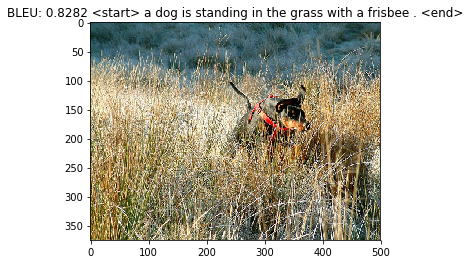

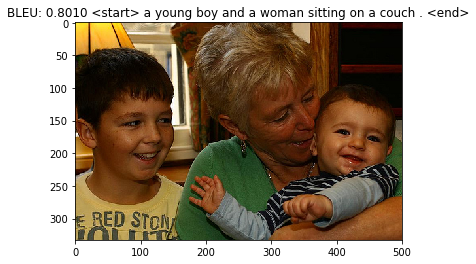

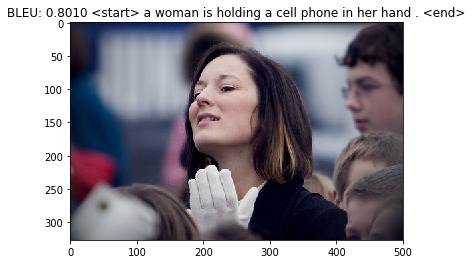

In [43]:
for sample in best_sample_results:
    plt.figure()
    input_image = Image.open(os.path.join(img_dir, sample['img_id']))
    plt.title('BLEU: ' + str(sample['bleu'])[:6] + ' ' + sample['caption'])
    plt.imshow(input_image)

##### Best Image Captioning Results (BLEU < 0.15)
Below are some bad examples of the image captioning from the network

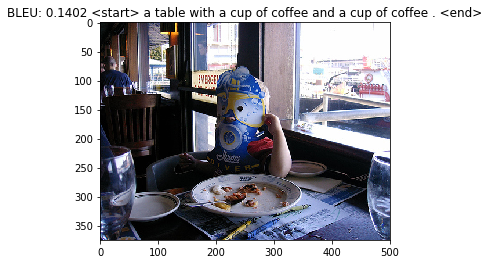

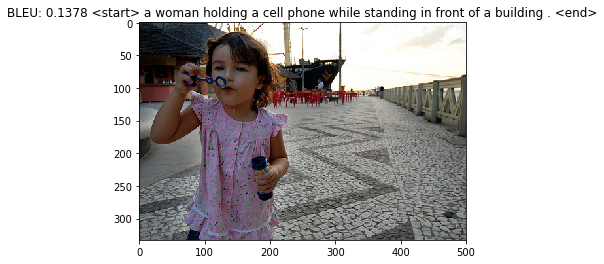

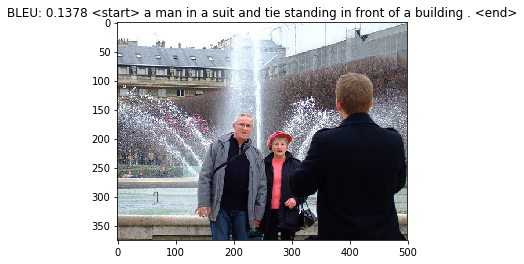

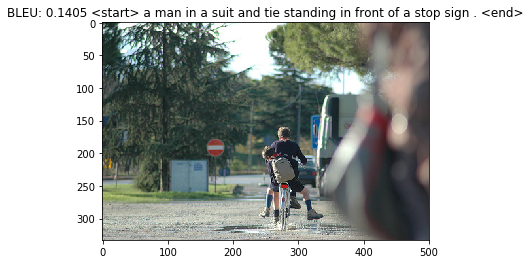

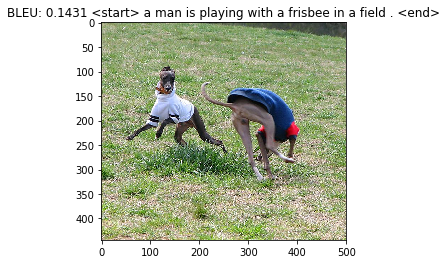

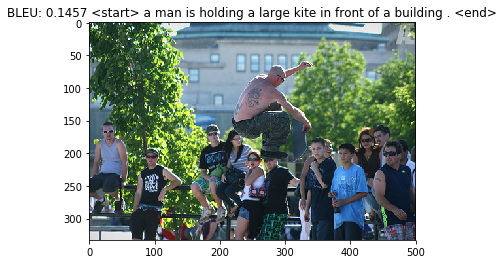

In [46]:
for sample in worst_sample_results:
    if sample['bleu'] < 0.15 :
        plt.figure()
        input_image = Image.open(os.path.join(img_dir, sample['img_id']))
        plt.title('BLEU: ' + str(sample['bleu'])[:6] + ' ' + sample['caption'])
        plt.imshow(input_image)